**Emotion Recognition based on facial landmarks**

This part of the practical session is about **emotion recognition** based on facial landmarks. We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) to recognize the emotion of a person by analyzing 68 facial landmarks (already estimated and placed). Below, you will find a picture with an example. We will focus on two emotions neutral and happy.

Please answer all questions and complete the code where you see **XXXXXXXXXXXXX**

**Deadline**: Upload this notebook, the one about Toy Examples and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

First of all, we need to load the data. In Google Colab, we can load from Google Drive or from our local machine. Since it's faster from Google Drive, let's load them from (my) Google Drive, using the following code.

In [1]:
import os
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./facial_landmarks_68markup.jpg')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the absolute path of your working directory with the data
Working_directory=os.getcwd().replace('\\','/')+'/data/'

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Otherwise, you can also load them from your local machine using the following code

In [2]:
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   
'''

'\nfrom google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))   \n'

Let's load the Python packages containing the functions needed for the practical session.

In [3]:
import numpy as np
from time import time

import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import paired_distances
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
# this is needed to plot figures within the notebook
%matplotlib inline 
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

from sklearn.pipeline import make_pipeline

We also load a user-defined function useful for plotting the confusion matrix

In [4]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Now, let's load the data. 

We have a list of images, the position of the original landmarks (aligned to the images), the position of the landmarks after a normalization process called Generalized Procrustes Analysis (please refer to https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis), the outputs with the class labels and the names of the images.

Generalized Procrustes Analysis (GPA) is used to keep only shape differences between the configurations of landmarks. That is to say, we align all configurations to an average one using only rigid transformations (uniform scaling, rotation and translation). This means that if I take a facial picture of subject A, then step back, translate and rotate a bit the camera and retake a facial picture of the same subject (who has not moved) the two picture will be different with therefore different landmark position. However, after a GPA, the two landmark configurations should be perfectly aligned removing the "nuisance" differences related to rotation, translation and uniform scaling.

In [5]:
# Parameters
dim=2 # dimension   
# Loading data
with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    X = data['Landmarks_FEI'] # original landmarks   
    XGPA = data['Landmarks_FEI_GPA'] # landmarks after GPA (Generalized Procrustes Analysis, https://en.wikipedia.org/wiki/Generalized_Procrustes_analysis)
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = X.shape # number subjects 
M = int(M/2) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

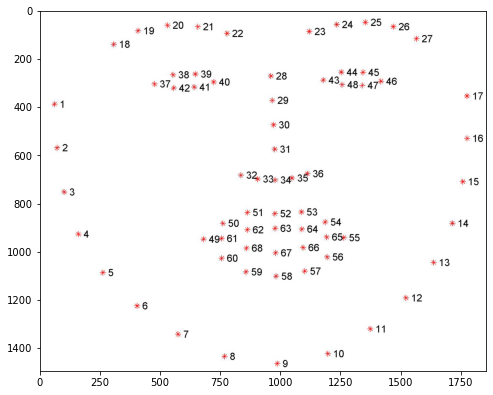

In [6]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (8,8)) # Size of the plot
plt.imshow(Example)
plt.show()

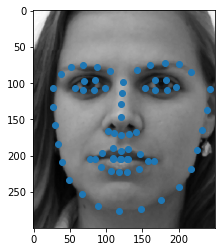

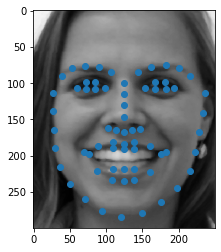

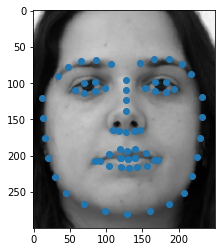

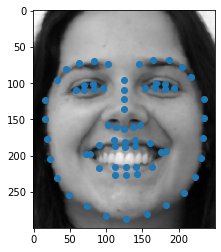

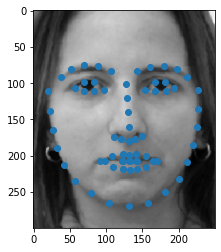

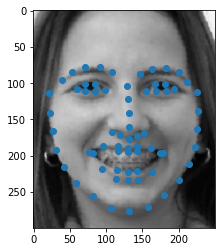

In [7]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Images[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()



---



**Question**: after plotting the first 6 images of the data-set, what do you notice ? Do you notice a regular pattern ? Do you think that it would be worth it to randomly shuffle the data ?




---



**Answer:**

We notice that for each neutral face, the image that follows is the same face but happy. It can lead to a bias and we have to randomly shuffle the data to avoid this bias.

In [8]:
# Shuffle data randomly. Hint: Use np.random.shuffle
indeces=np.arange(0, XGPA.shape[0])
np.random.shuffle(indeces)

XpGPA=XGPA[indeces]
Xp=X[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]
Xmean = np.mean(XpGPA,axis=0) # Compute average

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]]   



---



Among the loaded data, we also have aligned landmarks after a Generalized Procrustes Analysis. Let's check them and compare them with the landmarks before alignement.


**QUESTION**: Please comment the results. What can you notice ?




---



**ANSWER:**

After applying the GPA, the degree of variation in landmark positions decreases, particularly in the lower chin and nose regions. This can aid in identifying the subject's emotional state (happy or neutral), as the mouth is less prone to variation and represents the most crucial factor to detect the emotional state (at least visually).

Text(0.5, 1.0, 'Landmarks BEFORE alignement (GPA)')

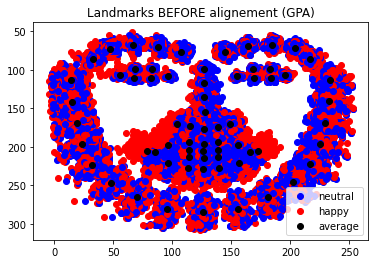

In [9]:
# Plot all landmarks BEFORE GPA
plt.figure()
for i in range(0,N):
    landmark=Xp[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
Xaverage = np.mean(Xp,axis=0) # Compute average
average=plt.scatter(Xaverage[::2],Xaverage[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis() 
plt.title('Landmarks BEFORE alignement (GPA)')

Text(0.5, 1.0, 'Landmarks AFTER alignement (GPA)')

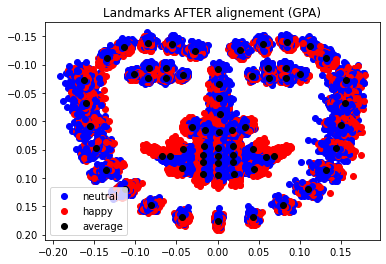

In [10]:
# Plot all landmarks AFTER GPA
plt.figure()
for i in range(0,N):
    landmark=XpGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yp[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
average=plt.scatter(Xmean[::2],Xmean[1::2],color='k')            
plt.legend((neutral,happy,average),('neutral','happy','average'))
plt.gca().invert_yaxis()   
plt.title('Landmarks AFTER alignement (GPA)')



---


We need now to compute some features for the classification algorithms. As first idea, we could use the paired Euclidean distances between the landmarks of every subject and the landmarks of the average configuration. 



---



In [11]:
# Compute distances from the average configuration (features)
dist_average=np.zeros((N,M))
average=np.reshape(Xmean,(M,2)) # Reshape average as matrix

for i in range(N):
    landmark=XpGPA[i].reshape((M,2)) # Reshape all landmarks as matrices
    dist_average[i]=paired_distances(landmark,average)
    
print('Number of subjects N is: ', dist_average.shape[0], ' ; number of features is: ',  dist_average.shape[1] )


Number of subjects N is:  400  ; number of features is:  68


Let's divide the data-set into Training and Test sets:

In [12]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(dist_average, np.ravel(Yp), test_size=0.33, random_state=42)

---

**Question**: One usual question in Machine Learning is, do we need to scale/normalize the features ? What do you think ? Should we do it in this case ? Compute both scaled and normalized data.

Please note that we compute the parameters of 'StandardScaler()' and 'MinMaxScaler()' using only the training set and then we trasform both the traning and test sets using the parameters learnt only on the training set.

**Question**: Why do we do that in your opinion ?

---

**Answers:**

1. When working with machine learning models, it is often a good practice to scale or normalize the features. This can help improve the performance of many algorithms, particularly those that are distance-based or rely on gradient descent optimization. Scaling the data can also help reduce the impact of outliers and make the data less sensitive to the scale of the input features.

    In this specific case, we are using a GPA (Generalized Procrustes Analysis) model, which is a method for aligning and comparing shapes. GPA does not explicitly require normalization, so we might skip this operation.
    

2. The reason for this approach is to properly separate the training and test sets to ensure that the model is only trained on the training set. However, pre-processing steps such as scaling and normalization are also part of the model. Therefore, it is necessary to transform the test data using the parameters learned on the training set to ensure that the model is evaluated on unseen data.

In [13]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

# Normalize data (each feature will be scaled into the range 0,1)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=minmaxscaler#sklearn.preprocessing.MinMaxScaler

normalizer=MinMaxScaler()
normalizer.fit(X_train)
X_train_normalize=normalizer.transform(X_train)
X_test_normalize=normalizer.transform(X_test)




---



Let's try to fit LDA to all training sets and predict the error on their respective test sets. 

**Question**: Compare the performnces between original, scaled and normalized data. Comment the results.



---



**Answer:**

As predicted before, as we are using `GPA`, results don't change if we scale or normalize our data. We see that the model detect quite well the neutral faces, but really struggles with happy ones (detect one over two).

Fitting LDA to training set
done in 0.017s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

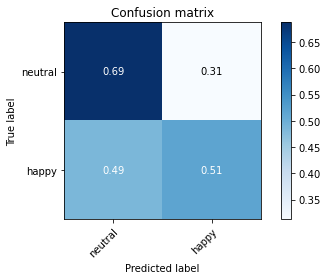

In [14]:
# Fitting LDA to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training scaled set
done in 0.012s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

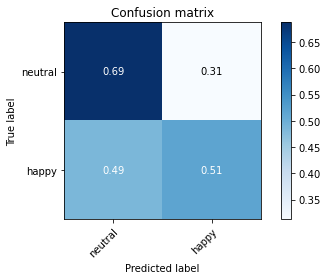

In [15]:
# Fitting LDA to scaled data
print("Fitting LDA to training scaled set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scale, y_train)
y_pred_scale = lda.predict(X_test_scale)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred_scale))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_scale)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Fitting LDA to training normalized set
done in 0.012s
              precision    recall  f1-score   support

           0       0.57      0.69      0.62        64
           1       0.64      0.51      0.57        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132

Normalized confusion matrix
[[0.6875     0.3125    ]
 [0.48529412 0.51470588]]


<Figure size 432x288 with 0 Axes>

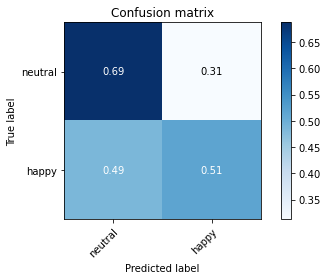

In [16]:
# Fitting LDA to normalized data
print("Fitting LDA to training normalized set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_normalize, y_train)
y_pred_normalize = lda.predict(X_test_normalize)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred_normalize))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_normalize)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()



---

We can then use the function 'cross_val_score' to compute the CV score. Let's use all methods seen today. 

---






In [17]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.058s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.049s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic Regression
done in 0.041s
 Average and std CV score : 0.5349999999999999 +- 0.0483476990145343
Fitting Naive-Bayes
done in 0.021s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting K-nearest neighbour
done in 0.049s
 Average and std CV score : 0.6049999999999999 +- 0.032210246816812824


---
**Question**: compare the performances between original, scaled and normalized data

Be careful, if you want to standardize your data within a cross validation it means that you should fit 'StandardScaler()' only to the K-1 training folds without using the K-th test fold ! And then transform all folds.
How can we do that ? 

Scikit-learn gives us a very nice tool: THE PIPELINE ! It makes it easier to chain standardization, normalizations, etc. with estimators during a cross validation. Please have a look here: https://scikit-learn.org/stable/common_pitfalls.html

How can we build a Pipeline? It's very simple. Just concatenate the trasformation and the the estimator you want to use:

model = make_pipeline(StandardScaler(), LinearRegression())

---


**Answer:**

It appears that the best result is when using `kNN`, with the original data. That gives us a mean of $60.5\%$ and a standard variation quite low, arround $3\%$.

We also can experience the fact that scaling the data does not affect the performances of methods `LDA`, `QDA` and `GNB`.

In [18]:
# Cross-validation for Model Assessment with Standaridzation

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda_standarized = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_standarized_score = cross_val_score(lda_standarized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_standarized_score.mean(), lda_standarized_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda_standarized = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
qda_standarized_score = cross_val_score(qda_standarized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_standarized_score.mean(), qda_standarized_score.std() ))
# Fitting Logistic-regression
print("Fitting Logistic")
t0 = time()
logit_standarized = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logit_standarized_score = cross_val_score(logit_standarized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_standarized_score.mean(), logit_standarized_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB_standarized = make_pipeline(StandardScaler(), GaussianNB())
GNB_standarized_score = cross_val_score(GNB_standarized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_standarized_score.mean(), GNB_standarized_score.std() ))

# Fitting K-nearest neighbour
print("Fitting KNN")
t0 = time()
neigh_standarized = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_standarized_score = cross_val_score(neigh_standarized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_standarized_score.mean(), neigh_standarized_score.std() ))

Fitting LDA
done in 0.076s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.062s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic
done in 0.236s
 Average and std CV score : 0.55 +- 0.01767766952966367
Fitting Naive-Bayes
done in 0.036s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting KNN
done in 0.057s
 Average and std CV score : 0.5625 +- 0.013693063937629145


In [19]:
# Cross-validation for Model Assessment with Normalization

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda_normalized = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis())
lda_normalized_score = cross_val_score(lda_normalized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_normalized_score.mean(), lda_normalized_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda_normalized = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis())
qda_normalized_score = cross_val_score(qda_normalized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_normalized_score.mean(), qda_normalized_score.std() ))
# Fitting Logistic-regression
print("Fitting Logistic")
t0 = time()
logit_normalized = make_pipeline(MinMaxScaler(), LogisticRegression(solver='lbfgs'))
logit_normalized_score = cross_val_score(logit_normalized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_normalized_score.mean(), logit_normalized_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB_normalized = make_pipeline(MinMaxScaler(), GaussianNB())
GNB_normalized_score = cross_val_score(GNB_normalized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_normalized_score.mean(), GNB_normalized_score.std() ))

# Fitting K-nearest neighbour
print("Fitting KNN")
t0 = time()
neigh_normalized = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=3))
neigh_normalized_score = cross_val_score(neigh_normalized,X=dist_average, y=np.ravel(Yp),cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_normalized_score.mean(), neigh_normalized_score.std() ))

Fitting LDA
done in 0.072s
 Average and std CV score : 0.5574999999999999 +- 0.045138675213169485
Fitting QDA
done in 0.057s
 Average and std CV score : 0.5625 +- 0.044721359549995794
Fitting Logistic
done in 0.126s
 Average and std CV score : 0.5675000000000001 +- 0.03409545424246464
Fitting Naive-Bayes
done in 0.033s
 Average and std CV score : 0.5725 +- 0.058843011479699094
Fitting KNN
done in 0.060s
 Average and std CV score : 0.5725 +- 0.033911649915626375


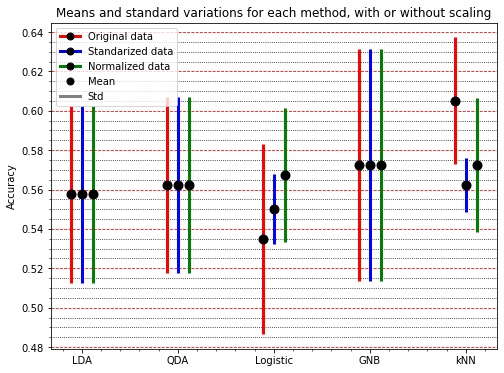

In [20]:
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

#Compare the results

labels = ['LDA', 'QDA', 'Logistic', 'GNB', 'kNN']
parameters = np.linspace(0, 1, len(labels))
delta = 1/7/len(labels)

means=[lda_score.mean(), qda_score.mean(), logit_score.mean(), GNB_score.mean(), neigh_score.mean()]
stds=[lda_score.std(), qda_score.std(), logit_score.std(), GNB_score.std(), neigh_score.std()]

means_standarized=[lda_standarized_score.mean(), qda_standarized_score.mean(), logit_standarized_score.mean(), GNB_standarized_score.mean(), neigh_standarized_score.mean()]
stds_standarized=[lda_standarized_score.std(), qda_standarized_score.std(), logit_standarized_score.std(), GNB_standarized_score.std(), neigh_standarized_score.std()]

means_normalized=[lda_normalized_score.mean(), qda_normalized_score.mean(), logit_normalized_score.mean(), GNB_normalized_score.mean(), neigh_normalized_score.mean()]
stds_normalized=[lda_normalized_score.std(), qda_normalized_score.std(), logit_normalized_score.std(), GNB_normalized_score.std(), neigh_normalized_score.std()]


# Create a boxplot of the data
plt.figure(figsize=(8, 6))
plt.errorbar(parameters - delta, means, stds, fmt='ok', ms=9, lw=3, ecolor='r', label='Original data')
plt.errorbar(parameters, means_standarized, stds_standarized, fmt='ok', ms=9, lw=3, ecolor='b', label='Standarized data')
plt.errorbar(parameters + delta, means_normalized, stds_normalized, fmt='ok', ms=9, lw=3, ecolor='g', label='Normalized data')

plt.ylabel('Accuracy')
plt.xticks(parameters, labels)

#Legend
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='r', lw=3, ms=7, label='Original data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='b', lw=3, ms=7, label='Standarized data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='g', lw=3, ms=7, label='Normalized data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', lw=0, ms=7, label='Mean'),
                   Line2D([0], [0], color='grey', lw=3, label='Std'),]


plt.legend(handles=legend_elements, loc='upper left')


plt.title("Means and standard variations for each method, with or without scaling")

# Show the grid and plot
plt.minorticks_on()
plt.grid(axis='y', linestyle='--', which='major', color='r')
plt.grid(axis='y', linestyle=':', which='minor', color='black')
plt.show()


---

In the previous example we have fixed the hyper-parameter K to 3. We could use CV to find the best value.

---



The best K is 7  with an average validation score equal to  0.6399999999999999


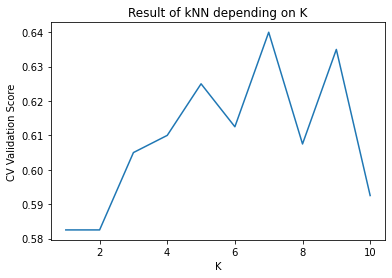

In [21]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(dist_average, np.ravel(Yp))

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')
plt.title('Result of kNN depending on K')
plt.show()



---



We could also use CV to assess the prediction error (generalization error) in a left-out test set.



---



The best K is 5  with an average validation score equal to  0.6044025157232704
The test score is 0.6590909090909091


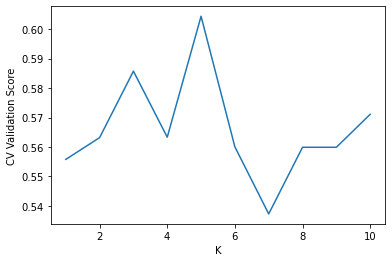

In [22]:
# We only use the training set for finding the best hyper-parameter
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# plot the CV validation score for each K value
plt.plot([1,2,3,4,5,6,7,8,9,10], grid.cv_results_.get('mean_test_score'))
plt.xlabel('K')
plt.ylabel('CV Validation Score')

# Let's now use the best model to assess the test score
BestModel=grid.best_estimator_
print('The test score is', BestModel.score(X_test, y_test))



---



**Question**: Comment the results of the two previous experiments. What about the best K and validation/test error ? Are the results the same ? Why in your opinion ?



---



**Answer**

The results of the two experiments are different in terms of the best value of `K` and the validation/test error. In the first experiment, the best value of `K` is found to be $7$ with a higher average validation score of $64\%$. However, in the second experiment, the best value of `K` is $5$ with a lower average validation score of $60\%$ but a higher test score of $65\%$.

These differences in the results could be due to overfitting in the first experiment. Since the hyperparameter tuning was performed on the entire dataset, the model may have learned the noise and idiosyncrasies of the data, leading to an over-optimistic estimate of the performance on the validation set. On the other hand, in the second experiment, the hyperparameter tuning was performed on the training set only, which may have led to a more realistic estimate of the model's performance on unseen data.

Moreover, in both experiments, the result is reletively poor as we only manage to success arround $60-65\%$, while deciding randomly gives us a success rate of $50\%$.



---



It seems that these features do not work very well... let's try to change them.
We can use the distances between all combinations of landmarks. Each subject has M*(M-1)/2 features.



---



In [23]:
# Use distances between all combinations of landmarks. Each subject has M*(M-1)/2 features
dist_combination=np.zeros((N,int((M*(M-1)/2))))
for k in range(N):
    landmark_k = XpGPA[k].reshape((M, 2))
    dist_sub_k = np.sqrt(((landmark_k[:, np.newaxis, :] - landmark_k) ** 2).sum(axis=2))
    dist_sub_k = dist_sub_k[np.triu_indices(M, k=1)] # extract upper triangular part
    dist_combination[k] = dist_sub_k
print('Number of subjects N is: ', dist_combination.shape[0], ' ; number of features is: ',  dist_combination.shape[1] )


Number of subjects N is:  400  ; number of features is:  2278


In [24]:
X2_train, X2_test, y2_train, y2_test = train_test_split(dist_combination, np.ravel(Yp), test_size=0.33, random_state=42)

**Question**: Should we scale/normalize the new features ?

**Answer:**
    
It appears than now that we have a lot more features, it seems to be a good idea to scale/normalize the new features. The reason for this is that unscaled or unnormalized features can have vastly different scales and ranges, which can lead to numerical instability and bias. For example, features with large scales and ranges can dominate the optimization process.

Use the classification algorithms seen before to test the discriminative power of the new features. 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-

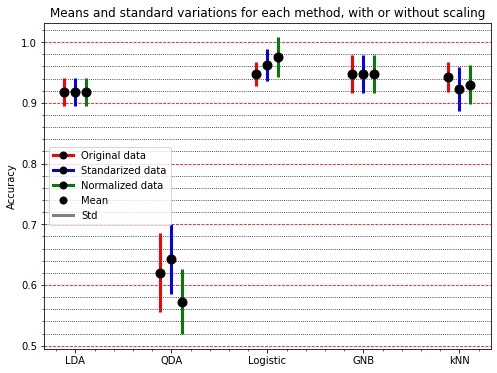

In [25]:
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

# Cross-validation for Model Assessment

scores=np.zeros((5,3,2))

methods=[LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression(solver='lbfgs'), GaussianNB(), KNeighborsClassifier(n_neighbors=3)]
for i in range(5):
    cross_val = cross_val_score(methods[i],X=dist_combination, y=np.ravel(Yp),cv=5)
    cross_val_scaled = cross_val_score(make_pipeline(StandardScaler(), methods[i]),X=dist_combination, y=np.ravel(Yp),cv=5)
    cross_val_normalized = cross_val_score(make_pipeline(MinMaxScaler(), methods[i]),X=dist_combination, y=np.ravel(Yp),cv=5)
    scores[i] = (cross_val.mean(), cross_val.std()),(cross_val_scaled.mean(), cross_val_scaled.std()),(cross_val_normalized.mean(), cross_val_normalized.std())

#Compare the results

labels = ['LDA', 'QDA', 'Logistic', 'GNB', 'kNN']
parameters = np.linspace(0, 1, len(labels))
delta = 1/7/len(labels)

# Create a boxplot of the data
plt.figure(figsize=(8, 6))
plt.errorbar(parameters - delta, scores[:,0,0], scores[:,0,1], fmt='ok', ms=9, lw=3, ecolor='r', label='Original data')
plt.errorbar(parameters, scores[:,1,0], scores[:,1,1], fmt='ok', ms=9, lw=3, ecolor='b', label='Standarized data')
plt.errorbar(parameters + delta, scores[:,2,0], scores[:,2,1], fmt='ok', ms=9, lw=3, ecolor='g', label='Normalized data')

plt.ylabel('Accuracy')
plt.xticks(parameters, labels)

#Legend
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='r', lw=3, ms=7, label='Original data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='b', lw=3, ms=7, label='Standarized data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='g', lw=3, ms=7, label='Normalized data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', lw=0, ms=7, label='Mean'),
                   Line2D([0], [0], color='grey', lw=3, label='Std'),]


plt.legend(handles=legend_elements, loc='center left')


plt.title("Means and standard variations for each method, with or without scaling")

# Show the grid and plot
plt.minorticks_on()
plt.grid(axis='y', linestyle='--', which='major', color='r')
plt.grid(axis='y', linestyle=':', which='minor', color='black')
plt.show()



---



mmmm it seems that some variables are collinear. Collinearity means that one variable can be linearly predicted by the others, basically it means that there is redundancy. 

**Question**: Which technique could you use to reduce the collinearity/redundancy ? Use it and test the predictive power of the new features.




---



**Answer:**

We can use PCA reduction.

That gives is better results, especially for `QDA`, but decreases the accuracy of `kNN`.

We kept 13 components.


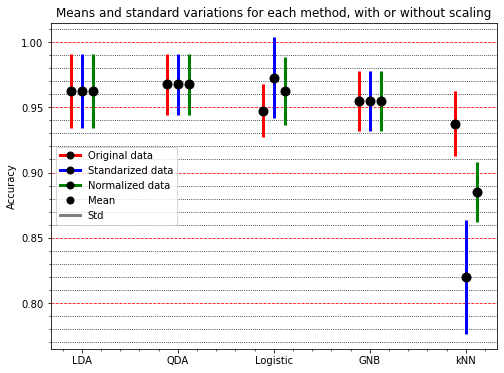

In [26]:
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

#Preprocessing
PCA = decomposition.PCA(n_components= 0.95)
dist_combinationPCA = PCA.fit_transform(dist_combination)
print(f"We kept {PCA.n_components_} components.")

# Cross-validation for Model Assessment

scores=np.zeros((5,3,2))

methods=[LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression(solver='lbfgs'), GaussianNB(), KNeighborsClassifier(n_neighbors=3)]
for i in range(5):
    cross_val = cross_val_score(methods[i],X=dist_combinationPCA, y=np.ravel(Yp),cv=5)
    cross_val_scaled = cross_val_score(make_pipeline(StandardScaler(), methods[i]),X=dist_combinationPCA, y=np.ravel(Yp),cv=5)
    cross_val_normalized = cross_val_score(make_pipeline(MinMaxScaler(), methods[i]),X=dist_combinationPCA, y=np.ravel(Yp),cv=5)
    scores[i] = (cross_val.mean(), cross_val.std()),(cross_val_scaled.mean(), cross_val_scaled.std()),(cross_val_normalized.mean(), cross_val_normalized.std())

#Compare the results

labels = ['LDA', 'QDA', 'Logistic', 'GNB', 'kNN']
parameters = np.linspace(0, 1, len(labels))
delta = 1/7/len(labels)

# Create a boxplot of the data
plt.figure(figsize=(8, 6))
plt.errorbar(parameters - delta, scores[:,0,0], scores[:,0,1], fmt='ok', ms=9, lw=3, ecolor='r', label='Original data')
plt.errorbar(parameters, scores[:,1,0], scores[:,1,1], fmt='ok', ms=9, lw=3, ecolor='b', label='Standarized data')
plt.errorbar(parameters + delta, scores[:,2,0], scores[:,2,1], fmt='ok', ms=9, lw=3, ecolor='g', label='Normalized data')

plt.ylabel('Accuracy')
plt.xticks(parameters, labels)

#Legend
legend_elements = [Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='r', lw=3, ms=7, label='Original data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='b', lw=3, ms=7, label='Standarized data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', color='g', lw=3, ms=7, label='Normalized data'),
                   Line2D([0], [0], marker='o', markeredgecolor='black', markerfacecolor='black', lw=0, ms=7, label='Mean'),
                   Line2D([0], [0], color='grey', lw=3, label='Std'),]


plt.legend(handles=legend_elements, loc='center left')


plt.title("Means and standard variations for each method, with or without scaling")

# Show the grid and plot
plt.minorticks_on()
plt.grid(axis='y', linestyle='--', which='major', color='r')
plt.grid(axis='y', linestyle=':', which='minor', color='black')
plt.show()



---


A second solution, would be to manually select few landmarks



---



In [27]:
# Select lateral landmarks mouth
select_land=[49,50,60,55,54,56]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

Number of subjects N is:  400  ; number of features is:  12


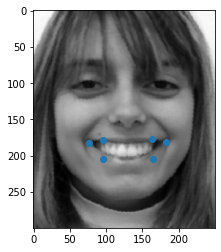

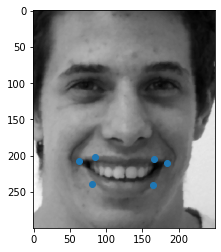

In [28]:
# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

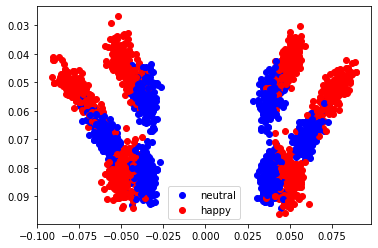

In [29]:
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()

In [30]:
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)

Fitting LDA
 Average and std train score : 0.95625 +- 0.006846531968814562
 Average and std test score : 0.9400000000000001 +- 0.021505813167606556


---

Let's plot some images where the best model was wrong. 

---

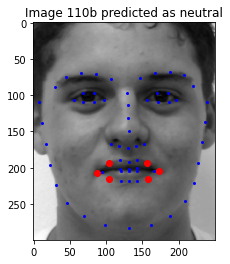

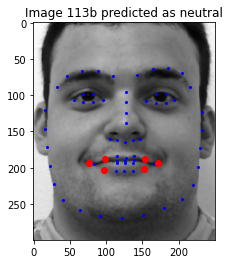

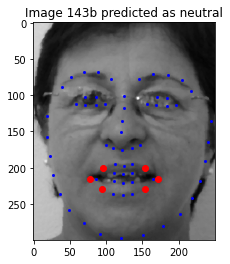

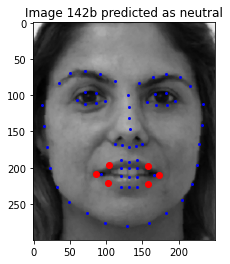

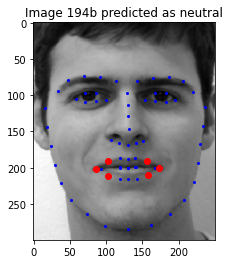

In [31]:
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob', markersize=2)
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()
 

**Question**: Comment the results. Why did the algorithm make a mistake ? Would you choose other landmarks ? Try at least another combination of landmarks


**Answer:**

The algorithm made a mistake over these faces because the selected landmarks were overlapping over the class of landmarks that correspond to neutral faces. Maybe we can test with landmarks at the corner of the eyes.

That does not work better.

Number of subjects N is:  400  ; number of features is:  12


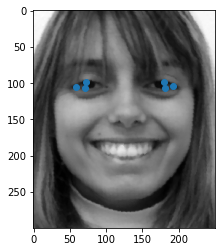

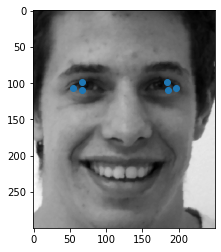

Fitting LDA
 Average and std train score : 0.81375 +- 0.009802741963348845
 Average and std test score : 0.7825000000000001 +- 0.026925824035672518


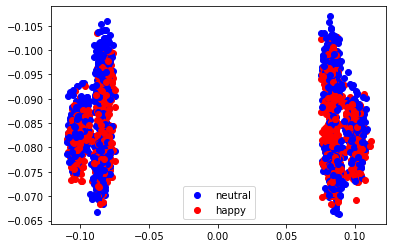

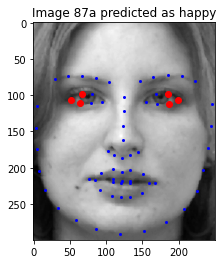

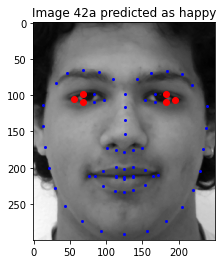

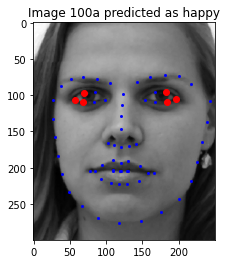

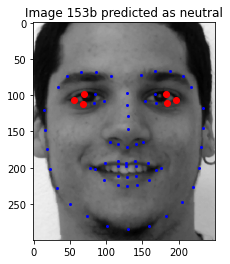

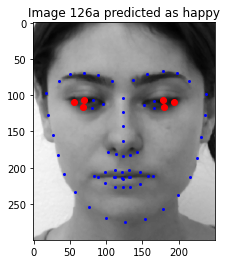

In [32]:
# Select lateral landmarks eyes
select_land=[37,38,42,45,46,47]
indeces_central=[]
for k in range(0,len(select_land)):
    indeces_central.append(select_land[k]*2-2) # Remember that landmarks are M*2 vectors (odds values are the x and even values are the y)
    indeces_central.append(select_land[k]*2-1)
    
indeces_central=np.array(indeces_central,dtype=int)
Ms=int(len(indeces_central)/2) 
Xps=np.zeros((N,Ms*dim))
XpsGPA=np.zeros((N,Ms*dim))
for i in range(0,N):
    XpsGPA[i,:]=XpGPA[i,indeces_central]
    Xps[i,:]=Xp[i,indeces_central]
    
Yps=Yp
  
print('Number of subjects N is: ', XpsGPA.shape[0], ' ; number of features is: ',  XpsGPA.shape[1] )  

# plot two test images 
for i in range(0,2):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=Xps[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()
# Plot only selected landmarks
plt.figure()
for i in range(0,N):
    landmark=XpsGPA[i]
    x=landmark[::2]
    y=landmark[1::2]
    if Yps[i].astype(int)==0:
        neutral=plt.scatter(x, y, c='b')
    else:
        happy=plt.scatter(x, y, c='r')
        
plt.legend((neutral,happy),('neutral','happy'))
plt.gca().invert_yaxis()
# Fitting LDA
print("Fitting LDA")
lda = LinearDiscriminantAnalysis()
lda_validate = cross_validate(lda,X=XpsGPA, y=np.ravel(Yps), cv=5, n_jobs=-1, return_train_score=True, return_estimator=True )
print(" Average and std train score : {0} +- {1}".format(lda_validate['train_score'].mean(), lda_validate['train_score'].std() ))
print(" Average and std test score : {0} +- {1}".format(lda_validate['test_score'].mean(), lda_validate['test_score'].std() ))

# Let's look for the best CV model (the one with the best test score)
best_estimator=lda_validate['estimator'][np.argmax(lda_validate['test_score'])]
C=best_estimator.predict(XpsGPA)

# Let's find the images where it did a mistake
error=np.ravel(np.array(np.where(np.abs(C-np.ravel(Yps)))))  
if len(error)>5:
    kk=5
else:
    kk=len(error)
# plot error images
for i in range(0,kk):
    image = Imagesp[error[i],:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmarkALL=Xp[error[i],:]
    landmark=Xps[error[i],:]
    xALL=landmarkALL[::2]
    yALL=landmarkALL[1::2]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(xALL,yALL,'ob', markersize=2)
    plt.plot(x,y,'or')
    if  C[error[i]]==0:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as neutral')
    elif C[error[i]]==1:
        plt.title('Image ' + Namesp[error[i]] + ' predicted as happy')
    plt.show()




---


Here, we use Nested Cross-Validation for finding the generalization error and the best K value



---



In [33]:
# Fitting K-nearest neighbour with Nested Cross-Validation
 
print("Fitting K-nearest neighbour with Nested CV")
t0 = time()
neigh = KNeighborsClassifier()
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666) # we fix the random state to always have the same results if we relaunch the code
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=666)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=neigh, param_grid=parameters, cv=inner_cv)
nested_CV = cross_validate(estimator=clf, X=XpsGPA, y=np.ravel(Yps), cv=outer_cv,return_train_score=True, return_estimator=True, n_jobs=-1)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv train score : {0} +- {1}".format(nested_CV['train_score'].mean(), nested_CV['train_score'].std() ))
print("Average and std Nested Cv test score : {0} +- {1}".format(nested_CV['test_score'].mean(), nested_CV['test_score'].std() ))

Fitting K-nearest neighbour with Nested CV
done in 0.940s
Average and std Nested Cv train score : 0.7606249999999999 +- 0.015761900266148123
Average and std Nested Cv test score : 0.71 +- 0.056678920243773176


---

**Question**: Are Training and Test scores similar ? What does it mean ?

---

**Answer:**
    
Their signification is completly different: train score represents how well the model is adapted to the data set over which it is trained, whereas test score represents the actual prediction score over unseen data.

Here, as we have a better train score than test score,  it can signify that our model is a bit overfit over the train set.

**Question (OPTIONAL)**: Please propose at least another set of features using landmarks and/or pixel intensities of the images and test its discriminative power